# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: TC5035.10 Proyecto Integrador**
### Tecnológico de Monterrey
### Dra. Grettel Barceló Alonso 
### Dr. Luis Eduardo Falcón Morales

## **Avance 2. Ingeniería de características**


**Nombres y matrículas de los integrantes del equipo:**
| Nombre | Matrícula |
| --- | --- |
| Rodrigo López Aguilera | A01793071 |
| Alejandra Mendoza Flores | A01793032 |
| Diego Carrera Nicholls | A00464290 |

In [1]:
%config Completer.use_jedi = False
# "python.dataScience.enablePlotViewer": false
# disable plot viewer
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.encoding import MeanEncoder

from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler, RobustScaler
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline

# sns.set(rc={"figure.dpi":100, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("whitegrid")


In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
def plot_boxplot_and_hist(data, variable):
    #figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True,
        gridspec_kw={"height_ratios": (0.50, 0.85)}
    )

    # assigning a graph to each ax
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.title(variable)
    plt.show()

In [5]:
def diagnostic_plots(df):
  # for every column in the dataframe, plot a histogram and a Q-Q plot of the data, on a nx2 grid

  # get the number of columns
  n_columns = df.shape[1]

  # create a figure with a grid of n_columns x 2
  fig, ax = plt.subplots(n_columns, 2, figsize=(15, 3*n_columns))

  # for every column, plot a histogram and a Q-Q plot
  for i, col in enumerate(df.columns):
    # plot histogram
    df[col].plot.hist(bins=50, ax=ax[i, 0])
    ax[i, 0].set_title(f'{col} histogram')

    # plot Q-Q plot
    stats.probplot(df[col], dist="norm", plot=ax[i, 1])
    ax[i, 1].set_title(f'{col} Q-Q plot')

  plt.tight_layout()
  plt.show()

In [6]:
def make_qqplot(df):
    # qq-plot of every column arranged on a grid
    n_columns = 4
    n_rows = int(np.ceil(df.shape[1] / n_columns))

    fig, ax = plt.subplots(n_rows, n_columns, figsize=(20, 4*n_rows))

    for i, col in enumerate(df.columns):
        stats.probplot(df[col], dist="norm", plot=ax[i//n_columns, i%n_columns])
        ax[i//n_columns, i%n_columns].set_title(col)

    plt.tight_layout()
    plt.show()



In [7]:
def plot_discrete_bins(variables, train, test):

  cols = 3
  rows = int(np.ceil(len(variables) / cols))

  fig, ax = plt.subplots(rows, cols, figsize=(15, 20))

  for i, var in enumerate(variables):

    plt.subplot(rows, cols, i+1)
     # determine proportion of observations per bin
    t1 = train[var].value_counts(normalize=True)
    t2 = test[var].value_counts(normalize=True)

    # concatenate proportions
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train', 'test']

    # sort the intervals
    tmp.sort_index(inplace=True)

    # plot the bar plot
    tmp.plot.bar(ax=ax[i//cols, i%cols], grid=True)
    plt.xticks(rotation=45, fontsize=6)

  plt.tight_layout()
  plt.show()

In [8]:
df = pd.read_csv('data/pickwin-active-users.csv')

Los datos presentados en las entregas anteriores fueron generados a partir de los siguientes datos mostrados a continuación.

| Columna | Descripción |
| --- | --- |
| days_since_registration | días desde el registro del usuario |
| purchases_count | número de compras |
| purchases_amount | monto total de compras |
| cashouts_count | número de retiros |
| cashouts_amount | monto total de retiros |
| total_bets | número total de apuestas |
| winning_bets | número de apuestas ganadas |
| losing_bets | número de apuestas perdidas |
| total_risk | monto total apostado |
| total_win | monto total ganado |
| net_win | total_win - total_risk ganancia neta |
| days_since_last_bet | días desde la última apuesta |

*churned* se calcula a partir de la fecha de última actividad del usuario, si esta es mayor a 30 días, se considera que el usuario ha abandonado la plataforma.

*days_since_last* bet se retira de la lista de carácterísticas porque sabemos de antemano que es una característica que dominará el modelo y además es una característica que se puede inferir haciendo una consulta en la base de datos.

De igual forma se eliminan la característica original de activity_ratio, que de igual forma dominará el modelo y es una característica que se puede inferir haciendo una consulta en la base de datos.


In [9]:
df.head()

,days_since_registration,purchases_count,purchases_amount,cashouts_count,cashouts_amount,total_bets,winning_bets,losing_bets,total_risk,total_win,net_win,churned
0,"2,553.79",1,300.00,0,0.00,1.00,0.00,1.00,300.00,0.00,-300.00,1
1,"2,207.00",1,25.00,0,0.00,2.00,0.00,2.00,30.00,0.00,-30.00,1
2,"2,063.79",1,200.00,0,0.00,14.00,12.00,1.00,200.00,0.00,-200.00,0
3,"2,060.46",1,500.00,0,0.00,1.00,0.00,1.00,500.00,0.00,-500.00,1
4,"2,006.88",3,250.00,0,0.00,9.00,1.00,8.00,320.00,19.39,-300.61,1


Revisión de valores nulos y duplicados

In [10]:
df.isnull().sum()

days_since_registration      0
purchases_count              0
purchases_amount             0
cashouts_count               0
cashouts_amount              0
total_bets                 501
winning_bets               501
losing_bets                501
total_risk                 501
total_win                  507
net_win                    507
churned                      0
dtype: int64

In [11]:
df = df.dropna()

In [12]:
df.duplicated().sum()

617

In [13]:
df = df.drop_duplicates()

Eliminacion de filas que contengan todos sus valores en 0

In [14]:
# remove all rows with zero values in all columns
df = df[(df.T != 0).any()]

Vamos a generar características adicionales que puedan ser útiles para el modelo.

Ganacias Netas o *net_winnings* que indicará el monto neto ganado por el usuario, es decir, la diferencia entre el monto total ganado y el monto total apostado siempre y cuando el valor sea positivo, si el valor es negativo se tomará como 0.

Perdidas Netas o *net_losses* que indicará el monto neto perdido por el usuario, es decir, la diferencia entre el monto total ganado y el monto total apostado siempre y cuando el valor sea negativo, si el valor es positivo se tomará como 0.

Generamos una variable categórica *winner* que nos indique si el usuario es un ganador o perdedor, es decir, si el usuario tiene ganancias netas positivas o negativas.

In [15]:
df['net_winnings'] = df.apply(lambda x: x['net_win'] if x['net_win'] > 0 else 0, axis=1)
df['net_losses'] = df.apply(lambda x: x['net_win'] if x['net_win'] < 0 else 0, axis=1).abs()
df['winner'] = np.where(df['net_win'] > 0, 1, 0)


A continuación generamos un nuevo conjunto de datos que indiquen las relaciones entre variables
| Columna | Descripción |
| --- | --- |
| win_ratio | winning_bets / total_bets que nos indicará el porcentaje de apuestas ganadas |
| risk_per_bet | total_risk / total_bets que nos indicará el monto promedio apostado por apuesta |
| net_winnings_per_bet | net_winnings / total_bets que nos indicará el monto promedio ganado por apuesta |
| net_losses_per_bet | net_losses / total_bets que nos indicará el monto promedio perdido por apuesta |


In [16]:
# relation of winning bets to total bets
df['win_ratio'] = df['winning_bets'] / df['total_bets']

# relation of risked money to total bets
df['risk_per_bet'] = df['total_risk'] / df['total_bets']

# relation of net winnings to total bets
df['net_winnings_per_bet'] = df['net_winnings'] / df['total_bets']

# relation of net losses to total bets
df['net_losses_per_bet'] = df['net_losses'] / df['total_bets']



In [17]:
df.head()

,days_since_registration,purchases_count,purchases_amount,cashouts_count,cashouts_amount,total_bets,winning_bets,losing_bets,total_risk,total_win,net_win,churned,net_winnings,net_losses,winner,win_ratio,risk_per_bet,net_winnings_per_bet,net_losses_per_bet
0,"2,553.79",1,300.00,0,0.00,1.00,0.00,1.00,300.00,0.00,-300.00,1,0.00,300.00,0,0.00,300.00,0.00,300.00
1,"2,207.00",1,25.00,0,0.00,2.00,0.00,2.00,30.00,0.00,-30.00,1,0.00,30.00,0,0.00,15.00,0.00,15.00
2,"2,063.79",1,200.00,0,0.00,14.00,12.00,1.00,200.00,0.00,-200.00,0,0.00,200.00,0,0.86,14.29,0.00,14.29
3,"2,060.46",1,500.00,0,0.00,1.00,0.00,1.00,500.00,0.00,-500.00,1,0.00,500.00,0,0.00,500.00,0.00,500.00
4,"2,006.88",3,250.00,0,0.00,9.00,1.00,8.00,320.00,19.39,-300.61,1,0.00,300.61,0,0.11,35.56,0.00,33.40


In [18]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
days_since_registration,"23,081.00","1,553.48",674.37,30.54,"1,085.83","1,640.62","2,075.00","3,174.88"
purchases_count,"23,081.00",7.20,39.64,1.00,1.00,1.00,3.00,"2,221.00"
purchases_amount,"23,081.00","5,332.49","115,966.32",10.00,100.00,250.00,700.00,"12,664,286.00"
cashouts_count,"23,081.00",0.95,5.78,0.00,0.00,0.00,0.00,228.00
cashouts_amount,"23,081.00","4,097.40","81,789.43",0.00,0.00,0.00,0.00,"8,297,350.00"
total_bets,"23,081.00",64.12,674.19,1.00,3.00,8.00,24.00,"67,543.00"
winning_bets,"23,081.00",15.94,186.71,0.00,0.00,1.00,5.00,"17,863.00"
losing_bets,"23,081.00",48.10,501.23,0.00,2.00,7.00,19.00,"49,680.00"
total_risk,"23,081.00","28,808.58","790,193.43",0.00,190.00,500.00,"1,752.00","65,245,852.00"
total_win,"23,081.00","27,415.82","755,897.97",0.00,0.00,125.40,"1,131.49","63,361,273.78"


### Histogramas de las características

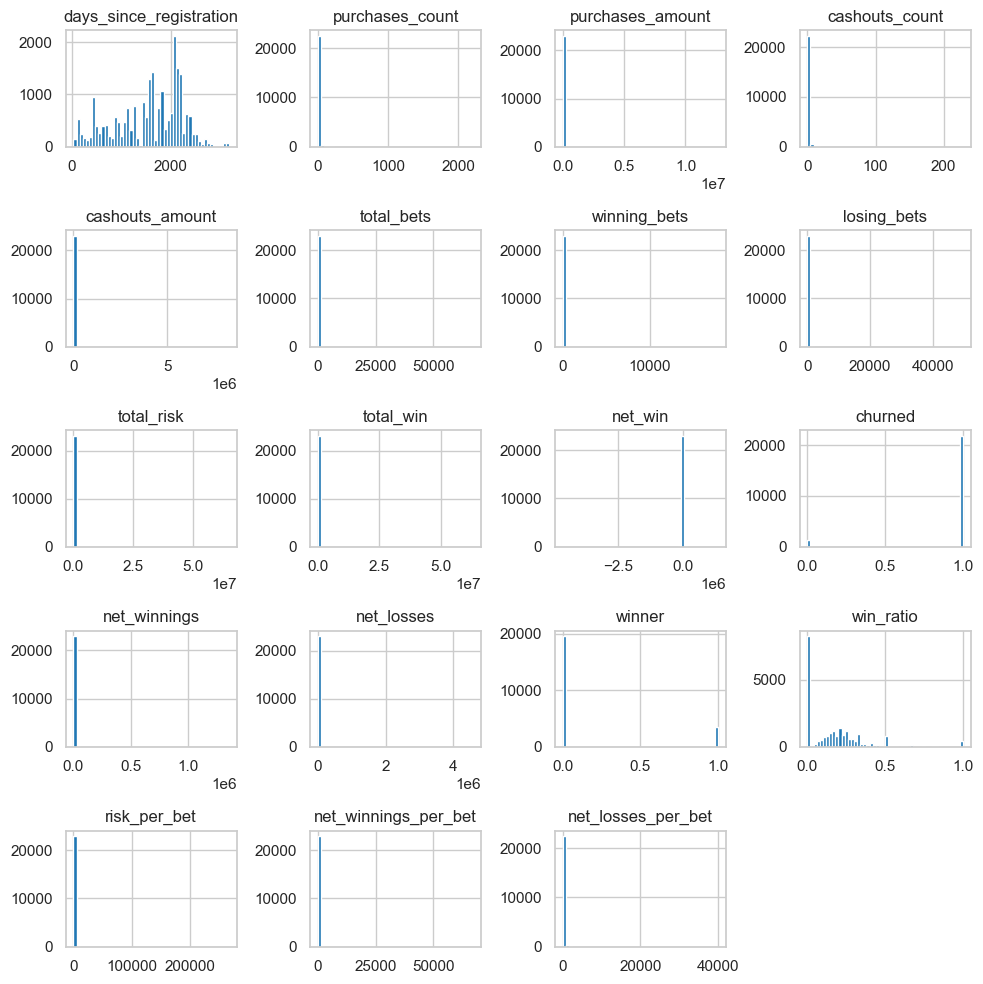

In [19]:
df.hist(bins=50, figsize=(10, 10))
plt.tight_layout()
plt.show()

### Boxplots de las características

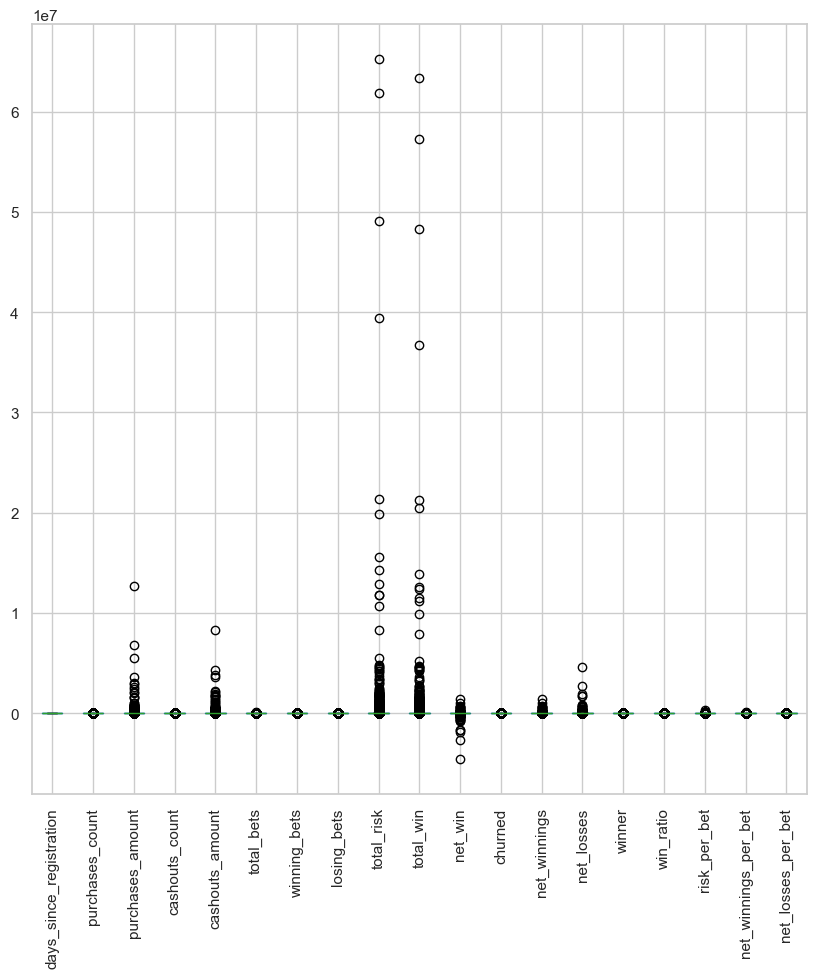

In [20]:
df.boxplot(figsize=(10, 10), rot=90)
plt.show()

De los histogramos y boxplots generados, se observa que las características tienen una distribución asimétrica y muchos valores atípicos por lo que exploraremos cuales son las posibles transformaciones y normalizaciones que podemos aplicar a las características.

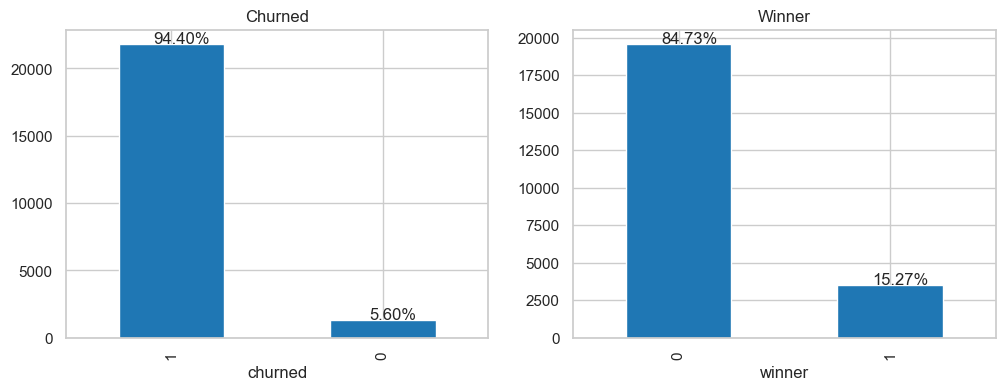

In [21]:
# plot of value counts for [churned, winner]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# plot subtitle
ax[0].set_title('Churned')
ax[1].set_title('Winner')

df['churned'].value_counts().plot(kind='bar', ax=ax[0])
# annotate the plot with the percentage of each category
for i in ax[0].patches:
    ax[0].text(i.get_x() + 0.3, i.get_height() + 50, f'{i.get_height()/df.shape[0]:.2%}', ha='center')

df['winner'].value_counts().plot(kind='bar', ax=ax[1])
# annotate the plot with the percentage of each category
for i in ax[1].patches:
    ax[1].text(i.get_x() + 0.3, i.get_height() + 50, f'{i.get_height()/df.shape[0]:.2%}', ha='center')

plt.show()


De igual forma podemos ver que la variable target *churned* está desbalanceada, por lo que exploraremos las posibles técnicas de balanceo que podemos aplicar.

### Explorando la perdida de información al realizar la eliminación de valores atípicos.

En la variable win_ratio eliminaremos de manera arbitraria los valores atípicos que se encuentren por encima del percentil 99 y por debajo del percentil 1.

In [22]:
churned_value_counts = df['churned'].value_counts()
churned_value_counts

churned
1    21788
0     1293
Name: count, dtype: int64

In [23]:
win_ratio_low = df['win_ratio'].quantile(0.01)
win_ratio_high = df['win_ratio'].quantile(0.99)

win_ratio_low, win_ratio_high

(0.0, 1.0)

In [24]:
filtered_churned_value_counts = df[(df['win_ratio'] > win_ratio_low) & (df['win_ratio'] < win_ratio_high)]['churned'].value_counts()
filtered_churned_value_counts

churned
1    13197
0     1182
Name: count, dtype: int64

In [25]:
# calculemos la perdida de información en la variable churned
( 1 - filtered_churned_value_counts / churned_value_counts ) * 100




churned
1   39.43
0    8.58
Name: count, dtype: float64

In [26]:
purchases_amount_low = df['purchases_amount'].quantile(0.01)
purchases_amount_high = df['purchases_amount'].quantile(0.99)

purchases_amount_low, purchases_amount_high

(25.0, 58162.40000000021)

In [27]:
filtered_purchases_amount_value_counts = df[(df['purchases_amount'] > purchases_amount_low) & (df['purchases_amount'] < purchases_amount_high)]['churned'].value_counts()
filtered_purchases_amount_value_counts

churned
1    21174
0     1179
Name: count, dtype: int64

In [28]:
( 1 - filtered_purchases_amount_value_counts / churned_value_counts ) * 100


churned
1   2.82
0   8.82
Name: count, dtype: float64

*Al eliminar los valores atípicos, se pierde entre el 8% y 9% de la clase minoritaria. y entre el 40% y 2% de la clase mayoritaria.*

No queremos perder información de la clase minoritaria, por lo que exploraremos otras técnicas para manejar los valores atípicos.

# Analizemos como se verian los datos si los transformamos en bins (discretización)

In [29]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.model_selection import train_test_split

In [30]:
X, y = df.drop(['churned'], axis=1), df['churned']
X.shape, y.shape


((23081, 18), (23081,))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
# variables a discretizar
variables = df.columns.drop(['churned', 'winner']).tolist()
eqf_d = EqualFrequencyDiscretiser(q=20, variables=variables, return_boundaries=True)

In [33]:
eqf_d.fit(X_train)

EqualFrequencyDiscretiser(q=20, return_boundaries=True,
                          variables=['days_since_registration',
                                     'purchases_count', 'purchases_amount',
                                     'cashouts_count', 'cashouts_amount',
                                     'total_bets', 'winning_bets',
                                     'losing_bets', 'total_risk', 'total_win',
                                     'net_win', 'net_winnings', 'net_losses',
                                     'win_ratio', 'risk_per_bet',
                                     'net_winnings_per_bet',
                                     'net_losses_per_bet'])

In [34]:
train_tf = eqf_d.transform(X_train)
test_tf = eqf_d.transform(X_test)

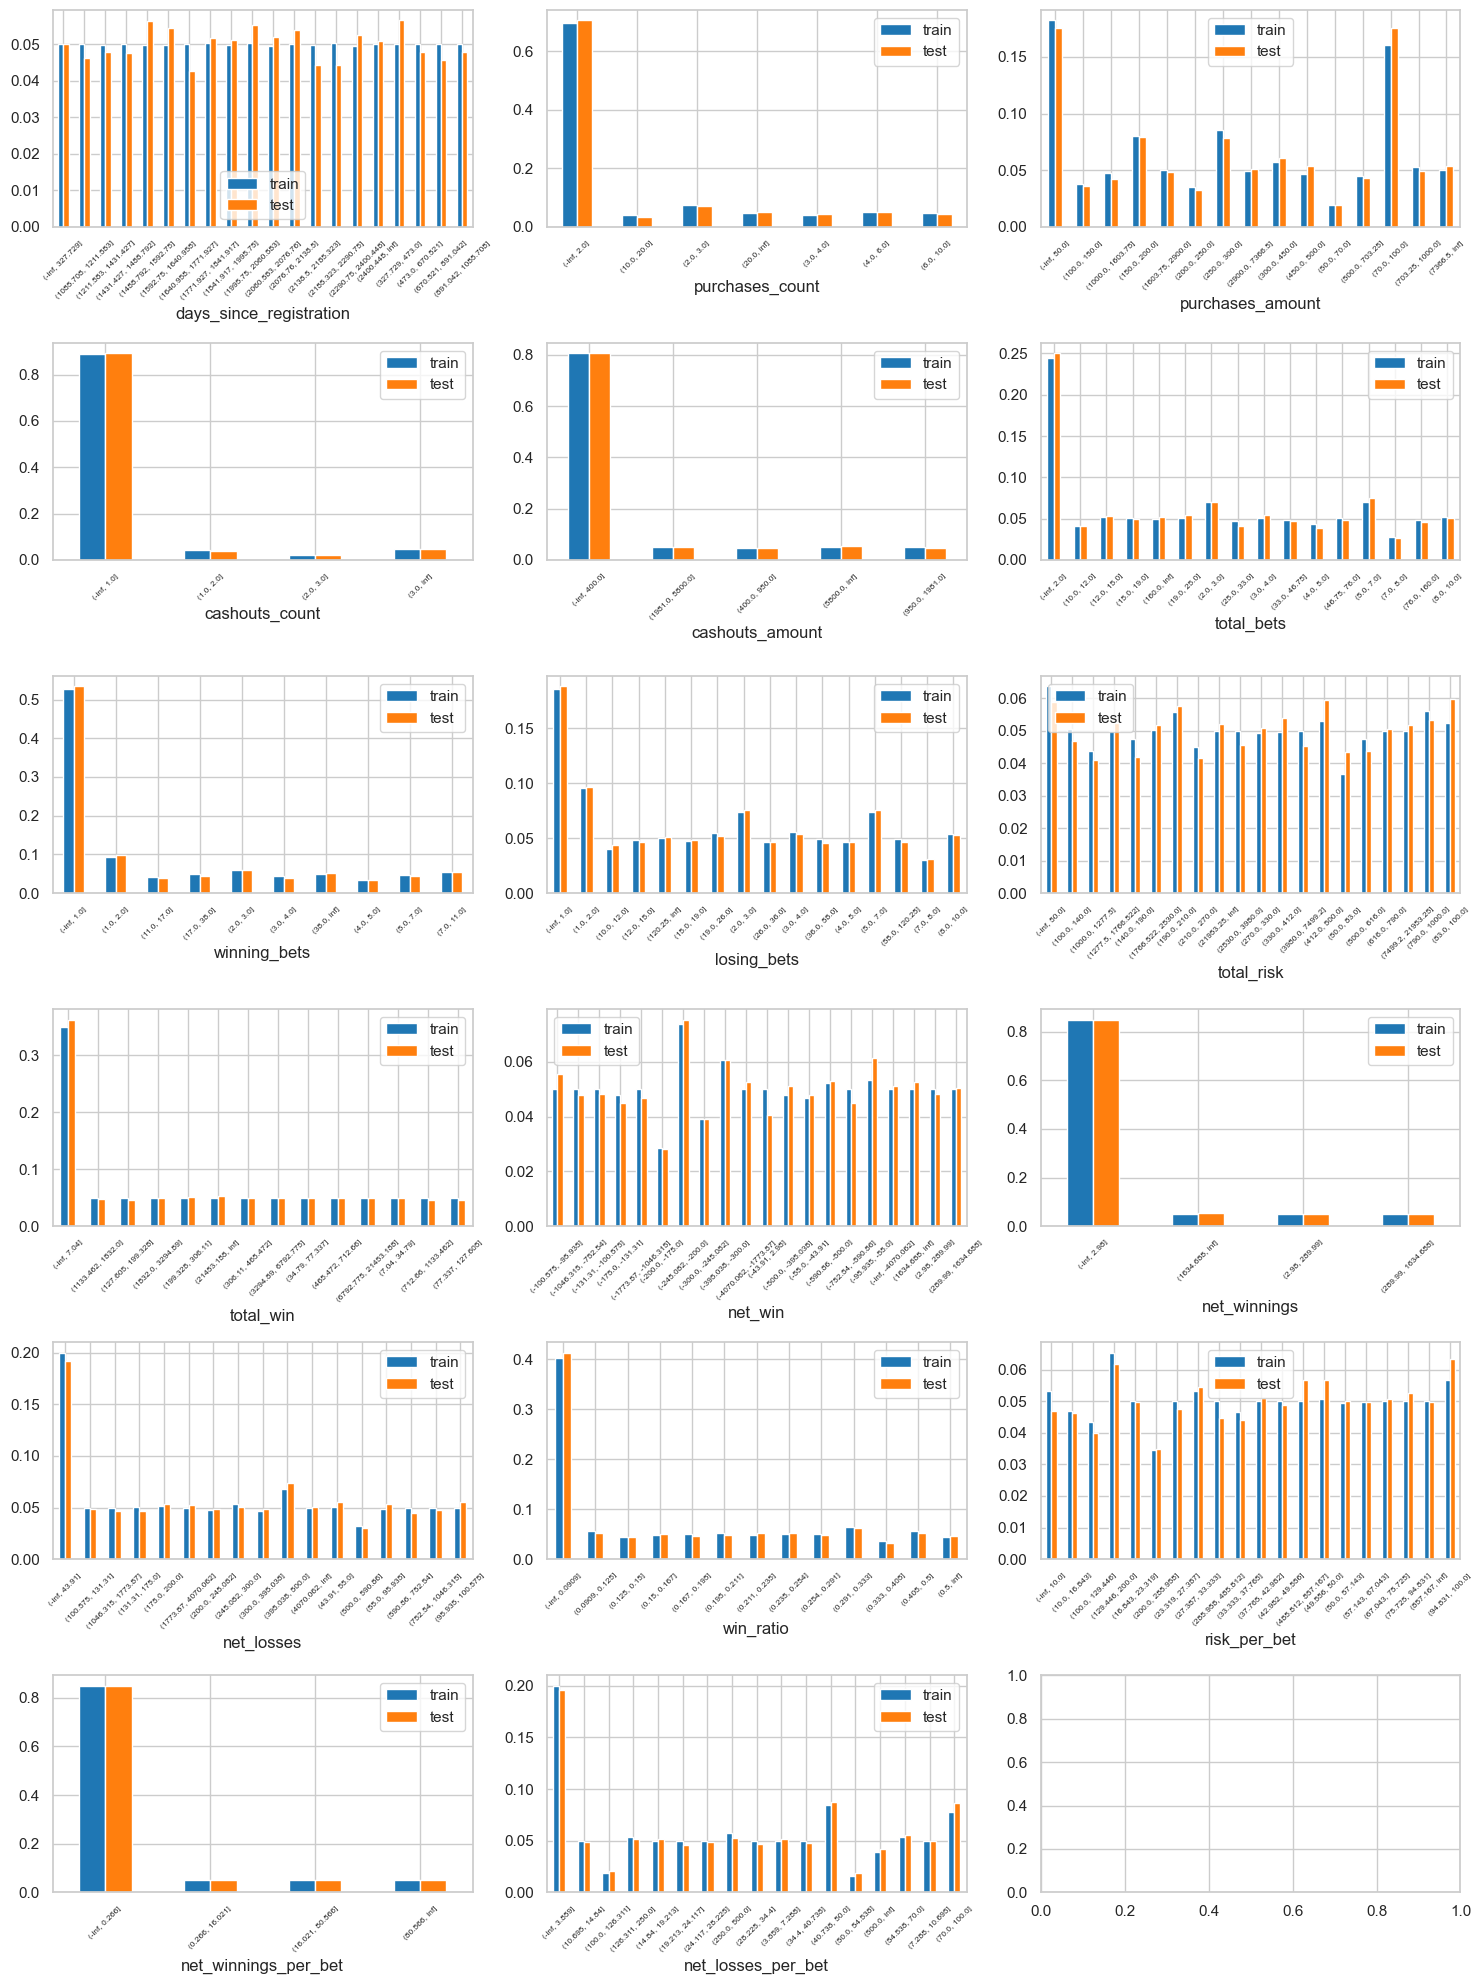

In [35]:
plot_discrete_bins(variables, train_tf, test_tf)

Creemos que la discretizacion de variables con 20 bins es una buena idea para poder manejar los valores atípicos y para poder manejar la distribución asimétrica de las características.

In [36]:
newDf = df[['net_winnings', 'cashouts_amount']]
newDf.describe()


,net_winnings,cashouts_amount
count,"23,081.00","23,081.00"
mean,975.54,"4,097.40"
std,"16,273.41","81,789.43"
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
max,"1,351,780.57","8,297,350.00"


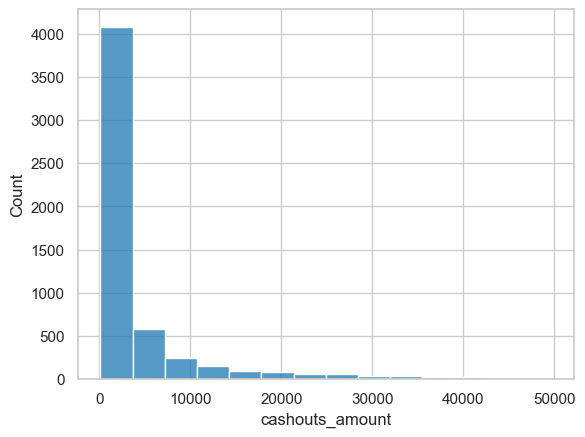

In [37]:

cashouts_amount_low = newDf['cashouts_amount'].quantile(0.01)
cashouts_amount_high = newDf['cashouts_amount'].quantile(0.99)


sns.histplot(data=newDf[(newDf['cashouts_amount'] > cashouts_amount_low) & (newDf['cashouts_amount'] < cashouts_amount_high)], x='cashouts_amount', bins="sturges")
plt.show()


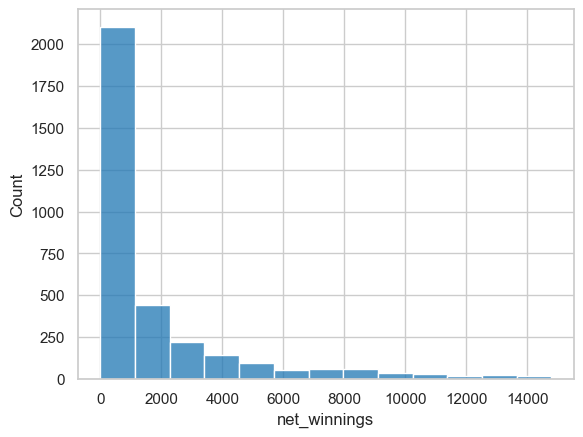

In [38]:
net_winnings_low = newDf['net_winnings'].quantile(0.01)
net_winnings_high = newDf['net_winnings'].quantile(0.99)

sns.histplot(data=newDf[(newDf['net_winnings'] > net_winnings_low) & (newDf['net_winnings'] < net_winnings_high)], x='net_winnings', bins="sturges")
plt.show()

In [39]:
X, y = df.drop(['churned'], axis=1), df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape)

(16156, 18) (6925, 18)


In [40]:
variables = df.columns.drop(['churned', 'winner']).tolist()
eqfd = EqualFrequencyDiscretiser(
  q=20,
  variables=variables,
  return_object=True
)

woe = MeanEncoder(variables=variables)

transformer = Pipeline(
  steps = [
    ('EqualFrequencyDiscretiser', eqfd),
    ('MeanEncoder', woe)
  ]
)

transformer.fit(X_train, y_train)

Pipeline(steps=[('EqualFrequencyDiscretiser',
                 EqualFrequencyDiscretiser(q=20, return_object=True,
                                           variables=['days_since_registration',
                                                      'purchases_count',
                                                      'purchases_amount',
                                                      'cashouts_count',
                                                      'cashouts_amount',
                                                      'total_bets',
                                                      'winning_bets',
                                                      'losing_bets',
                                                      'total_risk', 'total_win',
                                                      'net_win', 'net_winnings',
                                                      'net_losses', 'win_ratio',
                                                      'risk_per_bet',
                                                      'net_winnings_per_bet',
                                                      'net_losses_per_bet'])),
                ('MeanEncoder',
                 MeanEncoder(variables=['days_since_registration',
                                        'purchases_count', 'purchases_amount',
                                        'cashouts_count', 'cashouts_amount',
                                        'total_bets', 'winning_bets',
                                        'losing_bets', 'total_risk',
                                        'total_win', 'net_win', 'net_winnings',
                                        'net_losses', 'win_ratio',
                                        'risk_per_bet', 'net_winnings_per_bet',
                                        'net_losses_per_bet']))])

In [41]:
transformer.named_steps['EqualFrequencyDiscretiser'].binner_dict_

{'days_since_registration': [-inf,
  327.72915,
  473.0,
  670.5208500000002,
  891.0417,
  1085.7083,
  1211.5833,
  1431.4270999999999,
  1488.7917,
  1592.75,
  1640.9583,
  1771.9270999999999,
  1841.9167,
  1995.75,
  2060.5833,
  2076.760425,
  2138.5,
  2185.3229,
  2290.75,
  2400.447925,
  inf],
 'purchases_count': [-inf, 2.0, 3.0, 4.0, 6.0, 10.0, 20.0, inf],
 'purchases_amount': [-inf,
  50.0,
  70.0,
  100.0,
  150.0,
  200.0,
  250.0,
  300.0,
  450.0,
  500.0,
  703.25,
  1000.0,
  1603.750000000009,
  2900.0,
  7366.5,
  inf],
 'cashouts_count': [-inf, 1.0, 2.0, 3.0, inf],
 'cashouts_amount': [-inf, 400.0, 950.0, 1981.0, 5800.0, inf],
 'total_bets': [-inf,
  2.0,
  3.0,
  4.0,
  5.0,
  7.0,
  8.0,
  10.0,
  12.0,
  15.0,
  19.0,
  25.0,
  33.0,
  46.75000000000182,
  76.0,
  160.0,
  inf],
 'winning_bets': [-inf, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 11.0, 17.0, 38.0, inf],
 'losing_bets': [-inf,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  7.0,
  8.0,
  10.0,
  12.0,
  15.0,
  19.0,
  2

In [42]:
transformer.named_steps['MeanEncoder'].encoder_dict_

{'days_since_registration': {0: 0.8279702970297029,
  1: 0.9331683168316832,
  2: 0.9381188118811881,
  3: 0.905940594059406,
  4: 0.9455445544554455,
  5: 0.9455445544554455,
  6: 0.9045848822800495,
  7: 0.9616810877626699,
  8: 0.9479553903345725,
  9: 0.9318463444857497,
  10: 0.9591584158415841,
  11: 0.9778325123152709,
  12: 0.9328358208955224,
  13: 0.9618696186961869,
  14: 0.9763092269326683,
  15: 0.9826946847960445,
  16: 0.9813895781637717,
  17: 0.9668711656441717,
  18: 0.9375780274656679,
  19: 0.9405940594059405},
 'purchases_count': {0: 0.9835365311026074,
  1: 0.948073701842546,
  2: 0.9266467065868264,
  3: 0.9127837514934289,
  4: 0.8579017264276229,
  5: 0.7991071428571429,
  6: 0.610062893081761},
 'purchases_amount': {0: 0.9928692699490662,
  1: 0.9968652037617555,
  2: 0.9911162611046737,
  3: 0.9820554649265906,
  4: 0.986046511627907,
  5: 0.9647887323943662,
  6: 0.9818971759594497,
  7: 0.9794594594594594,
  8: 0.9710526315789474,
  9: 0.9752407152682255,
 

In [43]:
train_t = transformer.transform(X_train)
test_t = transformer.transform(X_test)

test_t.head()

,days_since_registration,purchases_count,purchases_amount,cashouts_count,cashouts_amount,total_bets,winning_bets,losing_bets,total_risk,total_win,net_win,net_winnings,net_losses,winner,win_ratio,risk_per_bet,net_winnings_per_bet,net_losses_per_bet
11881,0.94,0.98,0.98,0.96,0.97,0.96,0.95,0.96,0.99,0.99,0.97,0.95,0.97,0,0.94,0.98,0.95,0.95
14552,0.93,0.98,0.94,0.96,0.97,0.99,0.98,0.99,0.97,0.99,0.94,0.95,0.94,0,0.98,0.88,0.95,0.94
13883,0.96,0.98,0.98,0.96,0.97,0.96,0.98,0.95,0.99,0.99,0.97,0.95,0.98,0,0.98,0.93,0.95,0.96
8414,0.94,0.93,0.94,0.96,0.97,0.82,0.92,0.82,0.91,0.94,0.91,0.95,0.91,0,0.91,0.98,0.95,0.95
7642,0.95,0.86,0.77,0.96,0.97,0.96,0.94,0.96,0.85,0.94,0.68,0.95,0.68,0,0.91,0.88,0.95,0.93


In [44]:
print(train_t.shape, test_t.shape)

(16156, 18) (6925, 18)


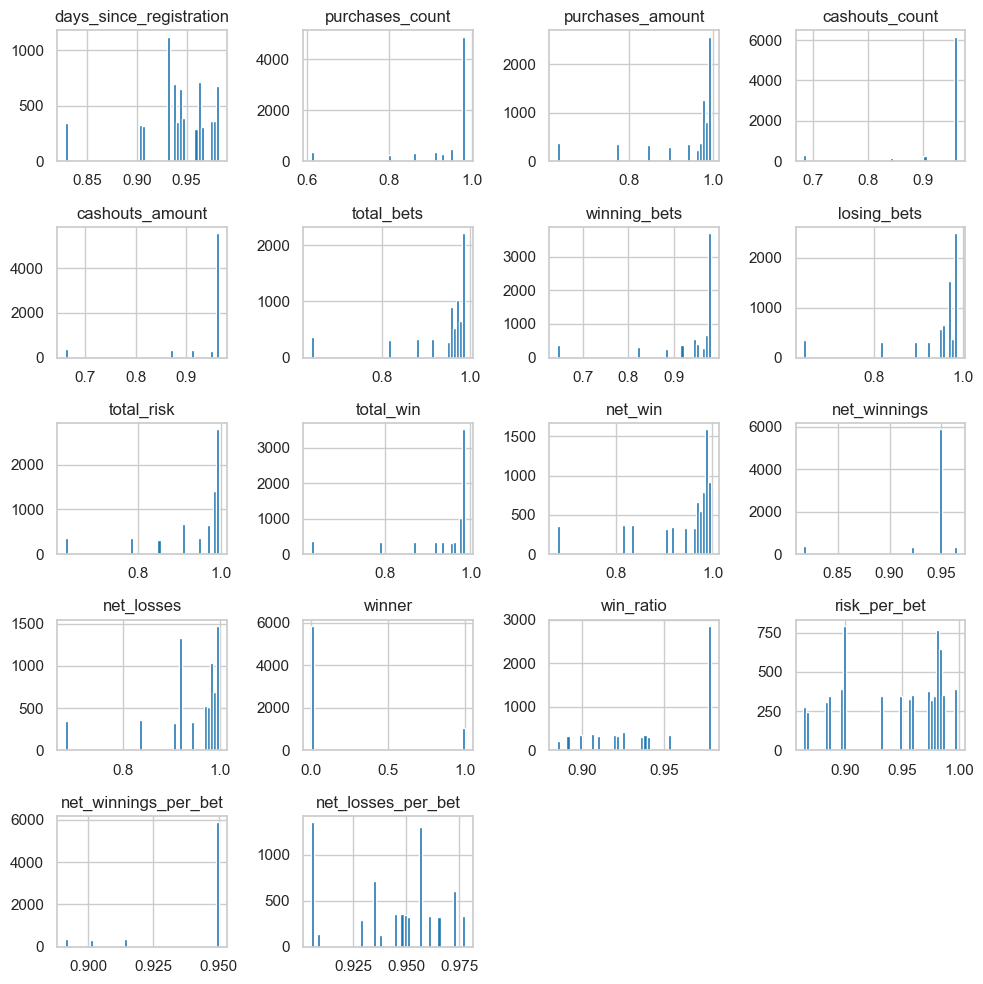

In [45]:
test_t.hist(bins=50, figsize=(10, 10))
plt.tight_layout()
plt.show()

In [46]:
train_t.columns

Index(['days_since_registration', 'purchases_count', 'purchases_amount',
       'cashouts_count', 'cashouts_amount', 'total_bets', 'winning_bets',
       'losing_bets', 'total_risk', 'total_win', 'net_win', 'net_winnings',
       'net_losses', 'winner', 'win_ratio', 'risk_per_bet',
       'net_winnings_per_bet', 'net_losses_per_bet'],
      dtype='object')

In [83]:
# do a pca analysis to see if we can reduce the number of variables
from sklearn.decomposition import PCA

pca = PCA(svd_solver='full', n_components=0.95, random_state=42)
pca.fit(train_t)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# find the names of the variables that are most important in the first component
pcaDf = pd.DataFrame(pca.components_, columns=train_t.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
pcaEv = pd.DataFrame(pca.explained_variance_ratio_, columns=['explained_variance_ratio'], index=[f'PC{i+1}' for i in range(pca.n_components_)])




[0.65532537 0.22635443 0.04190975 0.01837305 0.01583109]
[46.7913685  27.49994052 11.83299769  7.8348      7.27264863]


In [84]:
pcaDf.loc['PC1'].sort_values(ascending=False)

winner                     0.97
days_since_registration   -0.00
risk_per_bet              -0.01
win_ratio                 -0.03
net_losses_per_bet        -0.04
net_losses                -0.05
net_winnings_per_bet      -0.05
net_winnings              -0.05
purchases_amount          -0.06
losing_bets               -0.06
purchases_count           -0.06
total_bets                -0.06
cashouts_count            -0.07
winning_bets              -0.07
net_win                   -0.07
total_risk                -0.07
cashouts_amount           -0.10
total_win                 -0.11
Name: PC1, dtype: float64

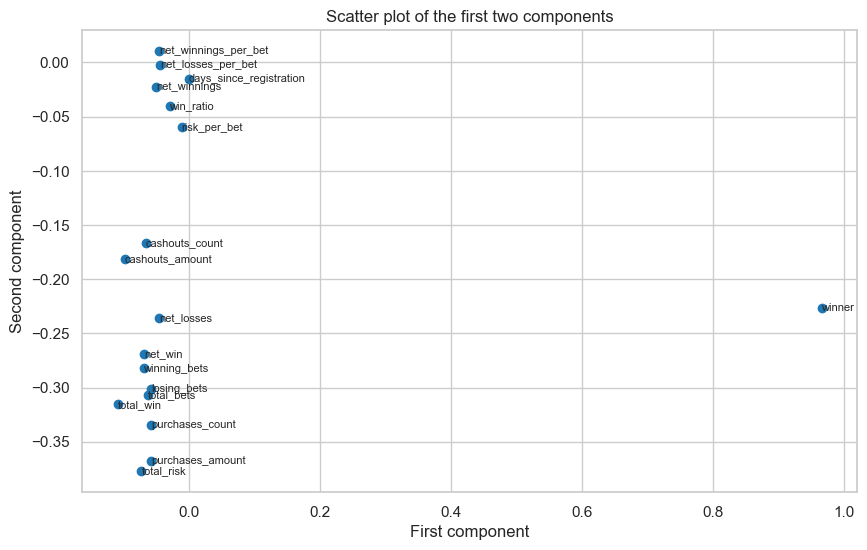

In [85]:
# scatter plot of the first two components
plt.figure(figsize=(10, 6))
plt.scatter(pcaDf.iloc[0], pcaDf.iloc[1])

for i, var in enumerate(pcaDf.columns):
    plt.text(pcaDf.iloc[0, i], pcaDf.iloc[1, i], var, fontsize=8, ha='left', va='center')


plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('Scatter plot of the first two components')
plt.show()


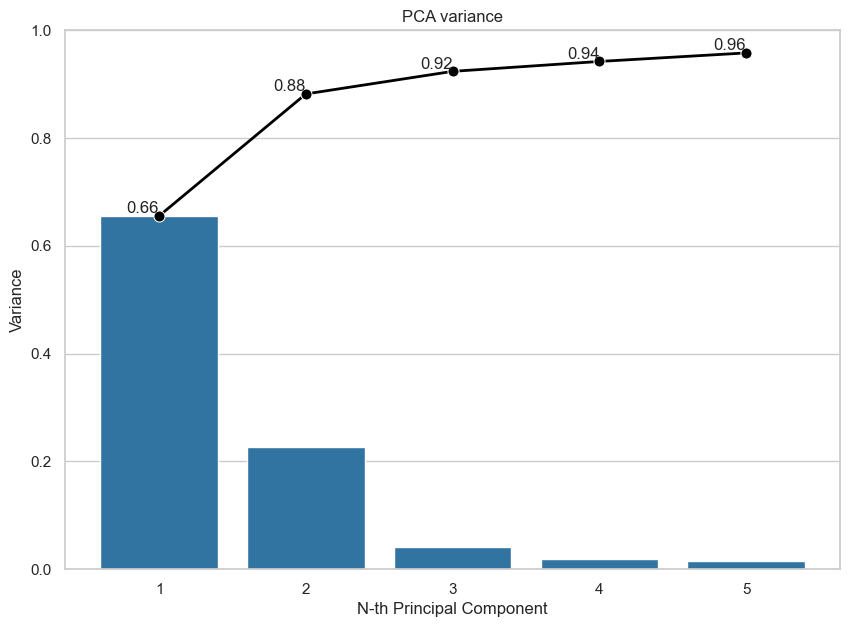

In [86]:
# plot the explained variance ratio with a scree plot
pc_components = np.arange(pca.n_components_) + 1

fig, ax = plt.subplots(figsize=(10,7))

cum_sum = np.cumsum(pca.explained_variance_ratio_)

_ = sns.barplot(x=pc_components, y=pca.explained_variance_ratio_)
_ = sns.lineplot(
  x=pc_components-1,
  y=cum_sum,
  color='black',
  linestyle='-',
  linewidth=2,
  marker='o',
  markersize=8
)
# anotate ticks for cumsum
for i in range(len(pca.explained_variance_ratio_)):
  ax.text(i, cum_sum[i], f'{cum_sum[i]:.2f}', ha='right', va='bottom')

plt.title('PCA variance')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance')
plt.ylim(0,1)
plt.show()

In [94]:
# https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

post_pca = pca.transform(train_t)
post_pcaDf = pd.DataFrame(post_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

In [90]:
n_pcs= pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = train_t.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

post_pcaDf.columns = most_important_names

['winner', 'total_risk', 'net_losses', 'cashouts_amount', 'purchases_count']


In [91]:
post_pcaDf.head()

,winner,total_risk,net_losses,cashouts_amount,purchases_count
0,-0.11,0.20,-0.04,-0.04,0.06
1,-0.18,-0.09,-0.01,0.02,-0.01
2,-0.17,-0.08,0.01,-0.02,-0.01
3,-0.18,-0.08,-0.01,0.02,0.01
4,0.99,0.46,0.09,0.22,-0.04


In [93]:
post_pcaDf.describe().T

,count,mean,std,min,25%,50%,75%,max
winner,"16,156.00",-0.00,0.37,-0.18,-0.18,-0.17,-0.12,1.04
total_risk,"16,156.00",0.00,0.22,-0.31,-0.10,-0.07,0.01,0.99
net_losses,"16,156.00",-0.00,0.09,-0.41,-0.03,-0.01,0.02,0.46
cashouts_amount,"16,156.00",0.00,0.06,-0.34,-0.02,0.01,0.02,0.39
purchases_count,"16,156.00",-0.00,0.06,-0.31,-0.01,-0.00,0.01,0.41


Realizando una reducción de dimensionalidad con PCA para obtener el 95% de la varianza explicada, observamos que se necesitan 5 componentes principales.
Losresultados dan que las variables
- winner
- total_risk
- net_losses
- cashouts_amount
- purchases_count

son las que más aportan a la varianza de los datos.

Sin embargo queremos explorar como otros comportamientos de los usuarios pueden estar relacionados con la variable target.

# Conclusiones y justificación del proceso

## Construcción

## Normalización

## Selección de características

## Conclusiones